In [96]:
import numpy as np
from numpy.linalg import inv

def get_radius(X, P):
    n = X.shape[0]
    m = P.shape[0]
    dx = np.zeros((m,n))
    dy = np.zeros((m,n))
    for k in range(m):
        dx[k,:] = (X[:,0] - P[k,0]).T
        dy[k,:] = (X[:,1] - P[k,1]).T
    return np.sqrt(np.power(dx,2)+np.power(dy,2)), dx, dy

def get_qpw(X, P, nu):
    r, dx, dy = get_radius(X, P)
    logr = np.log(r)
    r2 = np.power(r,2)
    return (3 - nu) * logr + (1+nu)*np.power(dy,2)/r2, (3 - nu) * logr + (1+nu)*np.power(dx,2)/r2, -(1+nu)*dx*dy / r2

def find_item_by_name(iterable, name):
        for it in iterable:
            if it.name == name:
                return it
        return None
    
def gpsgridder(stations, gpsdata, strain_range, grid_inc, nu = 0.3, dx = 0.0001, dy = 0.0001, eigenvalue_ratio = None):
    
    def convert_geographic_to_km(x, y, lat_center):
        return x * 111.13 * np.cos(np.deg2rad(lat_center)), y * 111.13
    
    names = [g.name for g in gpsdata if g.e is not np.nan and g.n is not np.nan]
    xi = np.array([find_item_by_name(stations, name).elon for name in names])
    yi = np.array([find_item_by_name(stations, name).nlat for name in names])
    ui = np.array([find_item_by_name(gpsdata, name).e for name in names])
    vi = np.array([find_item_by_name(gpsdata, name).n for name in names])
    
    (u0, v0) = (np.mean(ui), np.mean(vi))
    ui -= u0
    vi -= v0
    
    lat_center = np.mean(strain_range[2:3])
    
    xp, yp = convert_geographic_to_km(xi,yi,lat_center)
    n = xp.shape[0]
    (xp, yp) = (np.reshape(xp, (n, 1)), np.reshape(yp, (n, 1)))
    (ui, vi) = (np.reshape(ui, (n, 1)), np.reshape(vi, (n, 1)))
    X, Y = np.meshgrid(np.arange(strain_range[0], strain_range[1], grid_inc[0]), np.arange(strain_range[2], strain_range[3], grid_inc[1]))
    (ny, nx) = X.shape
    (xr, yr) = (np.reshape(X, (ny*nx, 1)), np.reshape(Y, (ny*nx, 1)))
    xgrid_p, ygrid_p = convert_geographic_to_km(xr, yr, lat_center)
    q, p, w = get_qpw(np.hstack((xp, yp)), np.hstack((xp+dx, yp+dy)), nu)
    if eigenvalue_ratio is None:
        wt = np.matmul(inv(np.vstack((np.hstack((q, w)),np.hstack((w, p))))), np.vstack((ui, vi)))
    else:
        from numpy.linalg import svd
        U, s, V = svd(np.vstack((np.hstack((q, w)),np.hstack((w, p)))))
        ev_ratio = s / s[0]
        i = np.where(ev_ratio < eigenvalue_ratio)
        s = np.diag(1 / s)
        s[i] = 0.0
        wt = np.matmul(np.matmul(V.T, s), np.matmul(U.T, np.vstack((ui, vi))))
    q, p, w = get_qpw(np.hstack((xp+dx, yp+dy)), np.hstack((xp, yp)), nu)
    (up, vp) = (u0 + np.matmul(q, wt[0:len(xi)]) + np.matmul(w, wt[len(xi):]), v0 + np.matmul(w,wt[0:len(xi)]) + np.matmul(p, wt[len(xi):]))
    q, p, w = get_qpw(np.hstack((xp+dx, yp+dy)), np.hstack((xgrid_p, ygrid_p)), nu)
    return np.flipud(X), np.flipud(Y), np.flipud(np.reshape(u0 + np.matmul(q,wt[0:len(xi)]) + np.matmul(w,wt[len(xi):]), (ny, nx))), np.flipud(np.reshape(v0 + np.matmul(w,wt[0:len(xi)]) + np.matmul(p,wt[len(xi):]), (ny, nx)))


In [97]:
import pickle as p
from gpsutils import gps_data_for_date_from_timeseries
import numpy as np
from datetime import datetime

(my_network, my_time_series) = p.load(open('data/GPSData.p', 'rb'))
strain_range=[-119.2,-118.6,37.47,37.82]
grid_inc = [0.001, 0.001]
nu = 0.25

gpsdata = gps_data_for_date_from_timeseries(np.datetime64(datetime(2017, 1, 17)), my_time_series)
stations = my_network.get_stations()

names = [g.name for g in gpsdata if g.e is not np.nan and g.n is not np.nan]
xi = np.array([find_item_by_name(stations, name).elon for name in names])
yi = np.array([find_item_by_name(stations, name).nlat for name in names])
ui = np.array([find_item_by_name(gpsdata, name).e for name in names])
vi = np.array([find_item_by_name(gpsdata, name).n for name in names])


(-119.2, -118.6, 37.47, 37.82)

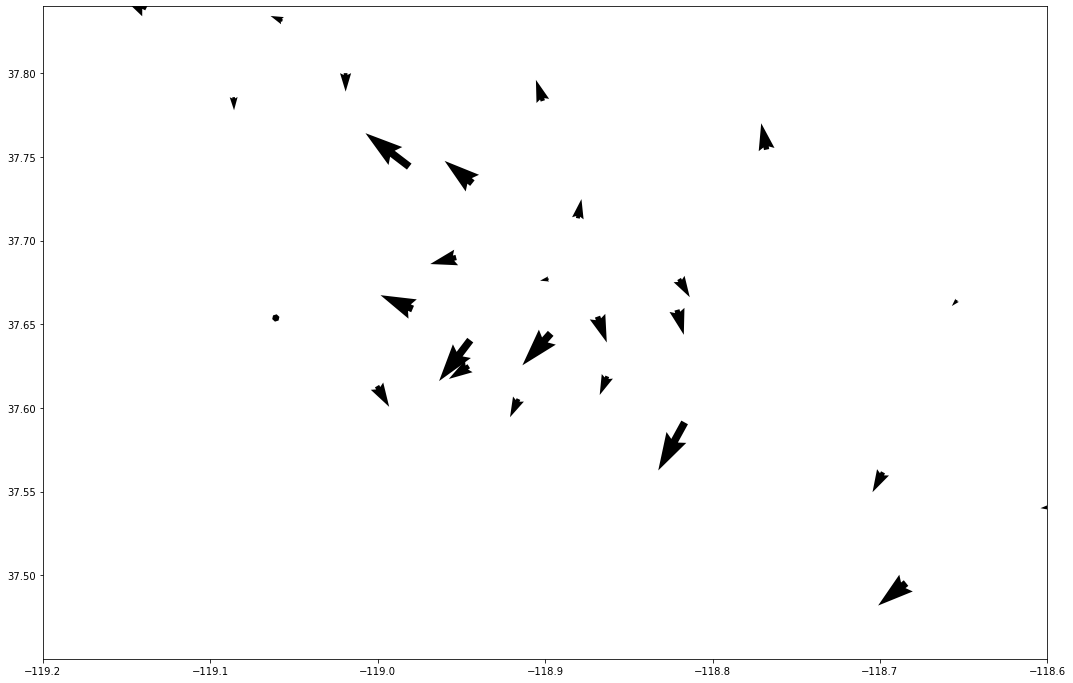

In [98]:
import matplotlib.pylab as plt

fig = plt.figure()
fig.set_size_inches(18, 12)
plt.quiver(xi, yi, ui, vi, scale=2E-1)
plt.axis('equal')
plt.axis(strain_range)


(-119.2, -118.6, 37.47, 37.82)

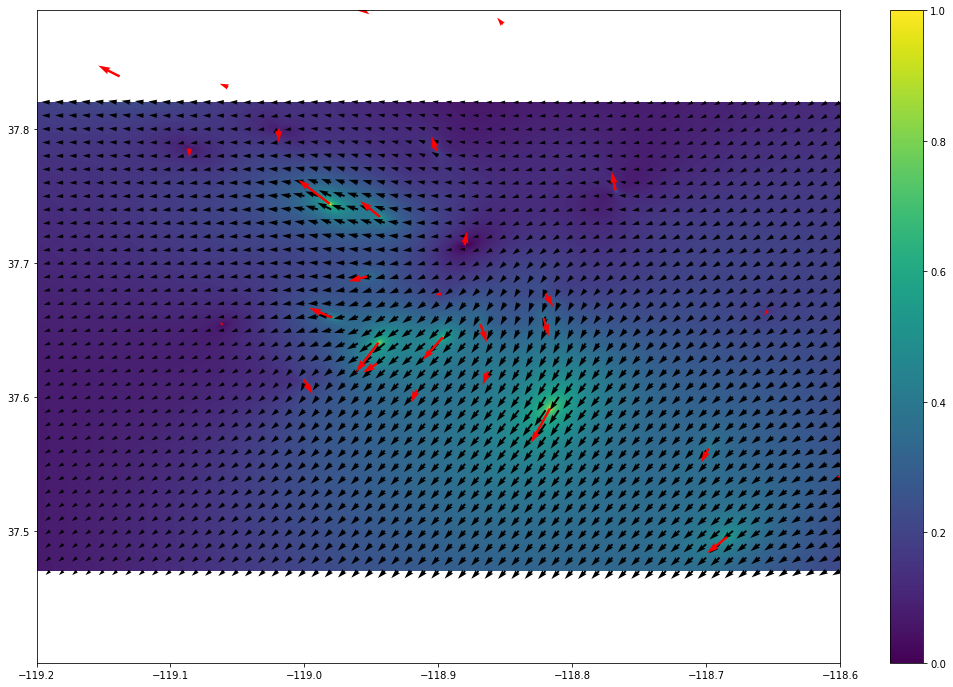

In [100]:
X, Y, Ux, Uy = gpsgridder(my_network.get_stations(), gpsdata, strain_range, grid_inc, nu)

spacing = 10
fig = plt.figure()
fig.set_size_inches(18, 12)
plt.imshow(np.sqrt(np.power(Uy,2)+np.power(Ux,2)), extent = strain_range)
plt.quiver(X[0::spacing,0::spacing], Y[0::spacing,0::spacing], Ux[0::spacing,0::spacing], Uy[0::spacing,0::spacing], scale = 2E-2, scale_units = 'inches')
plt.quiver(xi, yi, ui, vi, scale=2E-2, color = 'red', width = 0.003, scale_units = 'inches')
plt.colorbar()
plt.axis('equal')
plt.axis(strain_range)


In [102]:
Y

array([[37.82 , 37.82 , 37.82 , ..., 37.82 , 37.82 , 37.82 ],
       [37.819, 37.819, 37.819, ..., 37.819, 37.819, 37.819],
       [37.818, 37.818, 37.818, ..., 37.818, 37.818, 37.818],
       ...,
       [37.472, 37.472, 37.472, ..., 37.472, 37.472, 37.472],
       [37.471, 37.471, 37.471, ..., 37.471, 37.471, 37.471],
       [37.47 , 37.47 , 37.47 , ..., 37.47 , 37.47 , 37.47 ]])